In [1]:
from pathlib import Path

PROJECT_ROOT_DIR = str(Path.cwd().parent)
PROJECT_ROOT_DIR

'/root/llm_graph_embedder'

In [2]:
from huggingface_hub import notebook_login


notebook_login()

# Load evaluation data

In [3]:
import pandas as pd

test_data = pd.read_parquet(f"{PROJECT_ROOT_DIR}/dataset/test.parquet").sample(n=4000)

In [4]:
def format_test_conversations(sample):
    prompt_template = """<human>: {human_turn}\n\n<gpt>:"""

    return prompt_template.format(
        human_turn=sample["formatted_conversations"][0]["value"],
        gpt_turn=sample["formatted_conversations"][1]["value"],
    )

In [5]:
test_data["full_conversation"] = test_data.apply(format_test_conversations, axis=1)

In [6]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict(
    {
        "test": Dataset.from_pandas(
            test_data[["full_conversation"]].reset_index(drop=True)
        ),
    }
)

In [7]:
dataset

DatasetDict({
    test: Dataset({
        features: ['full_conversation'],
        num_rows: 4000
    })
})

# Load model with LoRA configuration

## Creating LoRA config

In [8]:
from peft import LoraConfig

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

## Loading Gemma 2 2B-it as `AutoModel`

In [9]:
import torch
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig

model_id = "google/gemma-2-2b-it"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
)

model = AutoModel.from_pretrained(
    model_id,
    quantization_config=bnb_config,
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
model.eval()

Gemma2Model(
  (embed_tokens): Embedding(256000, 2304, padding_idx=0)
  (layers): ModuleList(
    (0-25): 26 x Gemma2DecoderLayer(
      (self_attn): Gemma2Attention(
        (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
        (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
        (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
        (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        (rotary_emb): Gemma2RotaryEmbedding()
      )
      (mlp): Gemma2MLP(
        (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
        (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
        (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
        (act_fn): PytorchGELUTanh()
      )
      (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
      (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
      (pre_feedforward_layernor

In [11]:
model.to("cuda")

Gemma2Model(
  (embed_tokens): Embedding(256000, 2304, padding_idx=0)
  (layers): ModuleList(
    (0-25): 26 x Gemma2DecoderLayer(
      (self_attn): Gemma2Attention(
        (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
        (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
        (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
        (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        (rotary_emb): Gemma2RotaryEmbedding()
      )
      (mlp): Gemma2MLP(
        (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
        (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
        (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
        (act_fn): PytorchGELUTanh()
      )
      (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
      (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
      (pre_feedforward_layernor

# Generating embeddings

In [12]:
def generate_embeddings(sample):
    # Tokenize the input sentences
    inputs = tokenizer(
        sample,
        padding=True,
        truncation=True,
        max_length=3000,
        return_tensors="pt"
    )
    
    # Move inputs to GPU if available
    device = torch.device("cuda")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.last_hidden_state
        # Pooling: Mean pooling over the sequence length
        embeddings = hidden_states.mean(dim=1)
    
    # Convert embeddings to CPU and numpy for storage
    return embeddings.cpu().numpy()

In [13]:
%%time

test_data["embeddings"] = test_data[["full_conversation"]].map(generate_embeddings)

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


CPU times: user 5min 44s, sys: 1min, total: 6min 44s
Wall time: 6min 45s


In [14]:
test_data

,paper_id,title,abstract,publishing_year,label,id,graph,conversations,node_idx,formatted_conversations,full_conversation,embeddings
node_idx,,,,,,,,,,,,
108348,2980763643,scalable intelligence enabled networking with ...,In order to improve future network performance...,2019,8,arxiv_test_108348,"{'edge_index': [[1, 2, 3, 4, 5, 6, 0, 7, 8, 9,...","[{'from': 'human', 'value': 'Given a citation ...",108348,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.7886, -0.3423, -0.162, -0.35, -0.02888, 1...."
51638,2981698025,fraud detection in networks state of the art,Financial fraud detection represents the chall...,2019,24,arxiv_test_51638,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",51638,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.8613, -0.4749, -0.2815, -0.2666, -0.1366, ..."
165246,2989899878,degree bounded generalized polymatroids and ap...,"In the Bounded Degree Matroid Basis Problem, w...",2019,39,arxiv_test_165246,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 0, 8, 4,...","[{'from': 'human', 'value': 'Given a citation ...",165246,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.3826, -0.234, -0.072, 0.1421, 0.0348, 1.40..."
37768,2902788350,unsupervised deep slow feature analysis for ch...,Change detection has been a hotspot in the rem...,2019,16,arxiv_test_37768,"{'edge_index': [[1, 2, 3, 0, 4, 5, 6, 7, 8, 9,...","[{'from': 'human', 'value': 'Given a citation ...",37768,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.927, -0.4187, -0.1995, -0.2426, -0.004353,..."
39209,2936836152,harmonia near linear scalability for replicate...,Distributed storage employs replication to mas...,2019,5,arxiv_test_39209,"{'edge_index': [[1, 2, 3, 0, 4, 5, 6, 7, 8, 9,...","[{'from': 'human', 'value': 'Given a citation ...",39209,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.586, -0.3406, -0.2343, -0.05878, 0.2107, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...
89502,2945477881,generative flow via invertible nxn convolution,Flow-based generative models have recently bec...,2019,16,arxiv_test_89502,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",89502,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.8604, -0.5522, -0.2393, -0.23, 0.1273, 1.1..."
138306,2931612954,improving multilingual sentence embedding usin...,"In this paper, we present an approach to learn...",2019,30,arxiv_test_138306,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",138306,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.8853, -0.6685, -0.425, -0.2074, -0.0733, 1..."
54279,2971117199,information theoretic lower bounds for compres...,The goal of standard compressive sensing is to...,2019,28,arxiv_test_54279,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",54279,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.738, -0.5273, -0.353, -0.1837, -0.1506, 1...."


# Visualizing embeddings

In [17]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_embeddings(x_vals, y_vals, labels):
    random.seed(0)

    # Generate 40 distinct colors using a custom colormap
    cmap = ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20)).tolist() * 2)  # Extends tab20 to 40 colors

    plt.figure(figsize=(12, 12))

    scatter = plt.scatter(
        x_vals,
        y_vals,
        c=labels,
        cmap=cmap,  # Custom colormap with 40 colors
        s=10,       # Adjust size of points
        alpha=0.8   # Transparency
    )

    # Add a colorbar to show the mapping of colors to classes
    cbar = plt.colorbar(scatter, ticks=np.arange(0, 40, step=1))
    cbar.set_label("Classes")
    plt.title("2D Embedding Visualization with Class Colors")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

In [31]:
from umap.umap_ import UMAP


def reduce_dimensions(values):
    vectors = np.asarray(values)

    reducer = UMAP()
    reducer.fit(vectors)
    vectors = reducer.transform(vectors)
    

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals

In [33]:
%%time

x_coord, y_coord = reduce_dimensions(
    np.vstack(test_data["embeddings"].values),
    test_data["label"].values
)

/root/llm_graph_embedder/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 17.5 s, sys: 1min, total: 1min 18s
Wall time: 1min 10s


/root/llm_graph_embedder/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


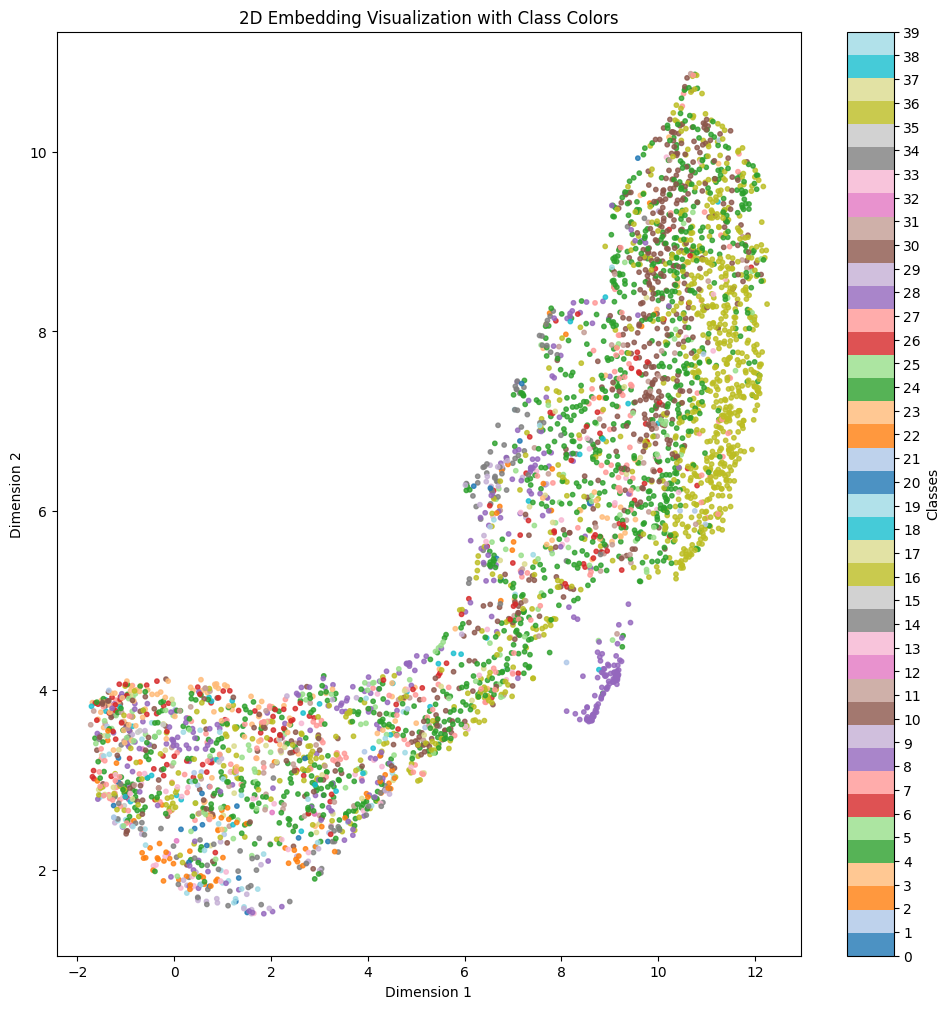

In [34]:
plot_embeddings(x_coord, y_coord, test_data["label"].values)